In [1]:
def get_df(name):
    """
    This function takes in the string
    'items', 'stores', or 'sales' and
    returns a df containing all pages and
    creates a .csv file for future use.
    """
    base_url = 'https://python.zach.lol'
    api_url = base_url + '/api/v1/'
    response = requests.get(api_url + name)
    data = response.json()
    
    # create list from 1st page
    my_list = data['payload'][name]
    
    # loop through the pages and add to list
    while data['payload']['next_page'] != None:
        response = requests.get(base_url + data['payload']['next_page'])
        data = response.json()
        my_list.extend(data['payload'][name])
    
    # Create DataFrame from list
    df = pd.DataFrame(my_list)
    
    # Write DataFrame to csv file for future use
    df.to_csv(name + '.csv')
    return df

######################### Params Helper function, can be used in big_df ###############################

def get_df_params(name):
    """
    This function takes in the string
    'items', 'stores', or 'sales' and
    returns a df containing all pages and
    creates a .csv file for future use.
    """
    # Create an empty list names `results`.
    results = []
    
    # Create api_url variable
    api_url = 'https://python.zach.lol/api/v1/'
    
    # Loop through the page parameters until an empty response is returned.
    for i in range(3):
        response =  requests.get(items_url, params = {"page": i+1})    
    
        # We have reached the end of the results
        if len(response.json()) == 0:   
            break
            
        else:
            # Convert my response to a dictionary and store as variable `data`
            data = response.json()
        
            # Add the list of dictionaries to my list
            results.extend(data['payload'][name])
    
    # Create DataFrame from list
    df = pd.DataFrame(results)
    
    # Write DataFrame to csv file for future use
    df.to_csv(name + '.csv')
    
    return df


def get_store_data():
    """
    This function checks for csv files
    for items, sales, stores, and big_df 
    if there are none, it creates them.
    It returns one big_df of merged dfs.
    """
    # check for csv files or create them
    if os.path.isfile('items.csv'):
        items_df = pd.read_csv('items.csv', index_col=0)
    else:
        items_df = get_df('items')
        
    if os.path.isfile('stores.csv'):
        stores_df = pd.read_csv('stores.csv', index_col=0)
    else:
        stores_df = get_df('stores')
        
    if os.path.isfile('sales.csv'):
        sales_df = pd.read_csv('sales.csv', index_col=0)
    else:
        sales_df = get_df('sales')
        
    if os.path.isfile('big_df.csv'):
        df = pd.read_csv('big_df.csv', index_col=0)
        return df
    else:
        # merge all of the DataFrames into one
        df = pd.merge(sales_df, stores_df, left_on='store', right_on='store_id').drop(columns={'store'})
        df = pd.merge(df, items_df, left_on='item', right_on='item_id').drop(columns={'item'})

        # write merged DateTime df with all data to directory for future use
        df.to_csv('big_df.csv')
        return df

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [3]:
df = get_store_data()

In [4]:
# def prep(df):
#     df['sale_date'] = pd.to_datetime(df.sale_date, format='%a, %d %b %Y %H:%M:%S %Z')
#     df = df.set_index('sale_date').sort_index()
#     df['month'] = df.index.month
#     df['day_of_week'] = df.index.dayofweek
#     df['sales_total'] = df.sale_amount * df.item_price
#     return df

In [5]:
# df = prep(df)

In [6]:
# df.head()

In [7]:
# sort values by date
# create dollars sold
# sale_amount to be items_sold
# aggregate daily by summing the values
# set index to date
def prep_data(df):
    return (df.assign(ds = pd.to_datetime(df.sale_date)).
            # sort values by date
            sort_values('ds').
            # create dollars sold
            assign(dollars_sold = df.sale_amount * df.item_price).
            # sale_amount to be items_sold
            assign(items_sold = df.sale_amount).
            # aggregate daily by summing the values
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().
            # set index to date
            reset_index().set_index('ds'))

df = prep_data(df)


In [8]:
df.head().T

ds,2013-01-01 00:00:00+00:00,2013-01-02 00:00:00+00:00,2013-01-03 00:00:00+00:00,2013-01-04 00:00:00+00:00,2013-01-05 00:00:00+00:00
dollars_sold,73844.01,73570.58,78169.48,84467.73,87621.85
items_sold,13696.00,13678.00,14488.00,15677.00,16237.00


In [9]:
# remove leap days

df = df[df.index != '2016-02-29']

# Split

- We will use the training proportion method to split.
- Identify the total length of the dataframe and multiple by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
- Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
- Return train and test dataframes.

In [10]:
train_size = int(len(df) * .5)
train_size

912

In [11]:
validate_size = int(len(df) * .3)

In [12]:
test_size = int(len(df) - train_size - validate_size)

In [13]:
validate_end_index = train_size + validate_size

Use those values to split our dataframe

In [14]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

Verify Splits

In [15]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [16]:
print(df.head(1) == train.head(1))

                           dollars_sold  items_sold
ds                                                 
2013-01-01 00:00:00+00:00          True        True


In [17]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30 00:00:00+00:00,120033.64,22296.0
2016-12-31 00:00:00+00:00,128009.31,23792.0


In [18]:
pd.concat([test.tail(1), df.tail(1)])


,dollars_sold,items_sold
ds,,
2017-12-31 00:00:00+00:00,140905.74,26420.0
2017-12-31 00:00:00+00:00,140905.74,26420.0


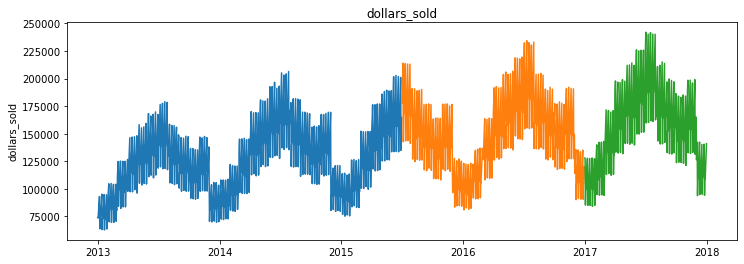

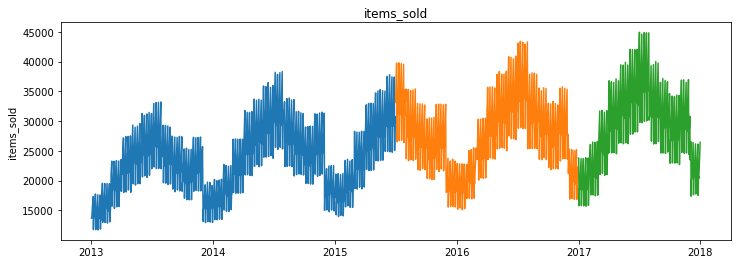

In [19]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [24]:
target_var = 'dollars_sold'


In [25]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

plot_and_eval() will use the evaluate function and also plot train and test values with the predicted values in order to compare performance

In [23]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [27]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [28]:
eval_df

,model_type,target_var,rmse


# Forecast

- Forecasting is another word for predicting time series data

**Last observed value**

- Make Predictions

In [36]:
dollars = round(train['dollars_sold'][-1:][0], 2)
dollars

164573.2

In [33]:
items = train['items_sold'][-1:][0]
items

30703.0

In [35]:
yhat_df = pd.DataFrame({'dollars_sold': [dollars], 
                        'items_sold': [items]},
                        index = validate.index)

yhat_df.head()
yhat_df.describe()

,dollars_sold,items_sold
count,5.470000e+02,547.0
mean,1.645732e+05,30703.0
std,1.660437e-09,0.0
min,1.645732e+05,30703.0
25%,1.645732e+05,30703.0
50%,1.645732e+05,30703.0
75%,1.645732e+05,30703.0
max,1.645732e+05,30703.0


**Plot Actual vs. Predicted Values**

dollars_sold -- RMSE: 35402


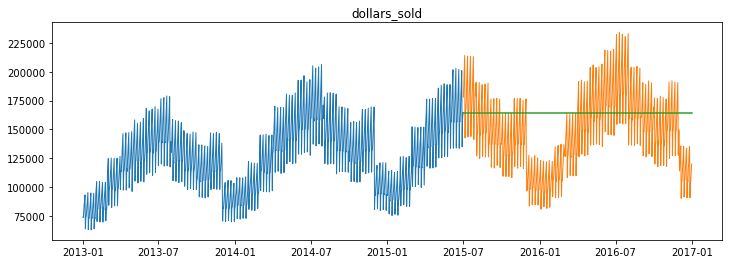

In [37]:
plot_and_eval('dollars_sold')

dollars_sold -- RMSE: 35402


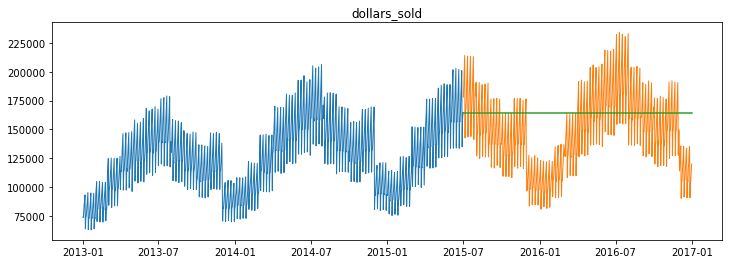

items_sold -- RMSE: 6621


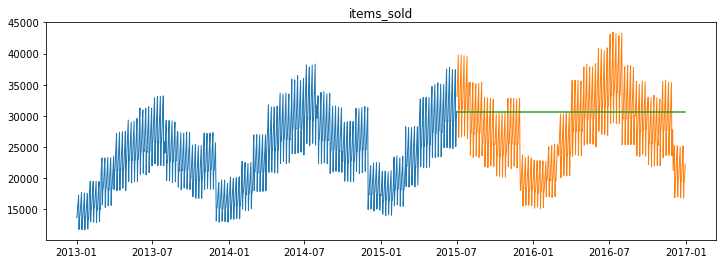

In [38]:
for col in train.columns:
    plot_and_eval(col)

# Evaluate

- Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [40]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_ovserved_value',
               target_var = col)
eval_df

,model_type,target_var,rmse
0,last_ovserved_value,dollars_sold,35402.0
1,last_ovserved_value,items_sold,6621.0


# Simple Average

- Make Predictions

- Dollars: establishing the value of the prediction we will make

In [45]:
# compute simple average

# plt.plot(train['dollars_sold'])
dollars = round(train['dollars_sold'].mean(), 2)

In [46]:
items = round(train['items_sold'].mean(), 2)
items

23717.94

In [47]:
# Aplly predictions to our observations

def make_predictions():
    yhat_df = pd.DataFrame({'dollars_sold': [dollars],
                           'items_sold': [items]},
                          index= validate.index)
    return yhat_df

In [49]:
yhat_df = make_predictions()

In [51]:
yhat_df.describe()

,dollars_sold,items_sold
count,5.470000e+02,5.470000e+02
mean,1.275179e+05,2.371794e+04
std,7.865227e-10,6.918487e-11
min,1.275179e+05,2.371794e+04
25%,1.275179e+05,2.371794e+04
50%,1.275179e+05,2.371794e+04
75%,1.275179e+05,2.371794e+04
max,1.275179e+05,2.371794e+04


**Plot Actual vs. Predicted**

dollars_sold -- RMSE: 39664


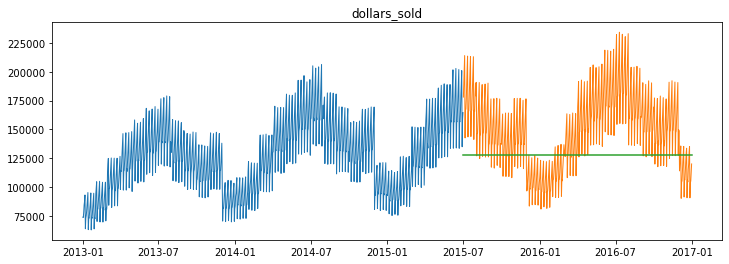

items_sold -- RMSE: 7378


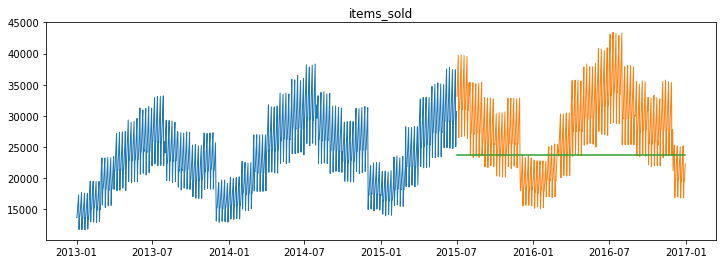

In [52]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [53]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average',
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_ovserved_value,dollars_sold,35402.0
1,last_ovserved_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0


# Moving Average

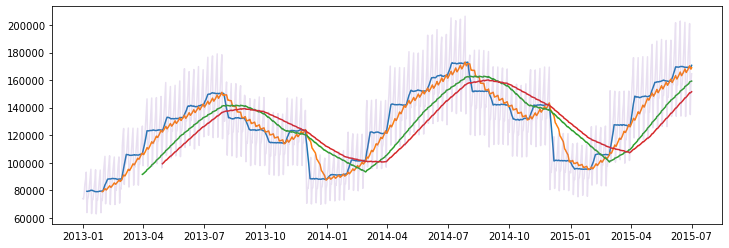

In [62]:
# train['dollars_sold'].tail(30)
plt.figure(figsize=(12,4))
plt.plot(train['dollars_sold'].rolling(7).mean())
plt.plot(train['dollars_sold'].rolling(30).mean())
plt.plot(train['dollars_sold'].rolling(90).mean())
plt.plot(train['dollars_sold'].rolling(120).mean())
plt.plot(train['dollars_sold'], alpha=.2)

In [ ]:
# demonstrate the mean of the first 30 days is equal to rolling(30) on day 30



**Make Predictions**


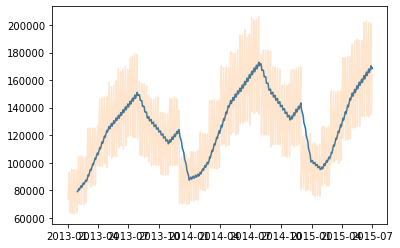

In [76]:
train['dollars_sold'].head(30).mean()
train['dollars_sold'].rolling(30).mean()

ds
2013-01-01 00:00:00+00:00              NaN
2013-01-02 00:00:00+00:00              NaN
2013-01-03 00:00:00+00:00              NaN
2013-01-04 00:00:00+00:00              NaN
2013-01-05 00:00:00+00:00              NaN
                                 ...      
2015-06-27 00:00:00+00:00    169307.076000
2015-06-28 00:00:00+00:00    170365.098000
2015-06-29 00:00:00+00:00    168925.788333
2015-06-30 00:00:00+00:00    167925.392000
2015-07-01 00:00:00+00:00    168957.912000
Name: dollars_sold, Length: 912, dtype: float64

In [77]:
period = 30

dollars = round(train['dollars_sold'].rolling(period).mean()[-1], 2)
items = round(train['items_sold'].rolling(period).mean()[-1],2)

print(dollars, items)

168957.91 31432.77


In [78]:
yhhat_df = make_predictions()
yhat_df.head()

,dollars_sold,items_sold
ds,,
2015-07-02 00:00:00+00:00,127517.85,23717.94
2015-07-03 00:00:00+00:00,127517.85,23717.94
2015-07-04 00:00:00+00:00,127517.85,23717.94
2015-07-05 00:00:00+00:00,127517.85,23717.94
2015-07-06 00:00:00+00:00,127517.85,23717.94


dollars_sold -- RMSE: 39664


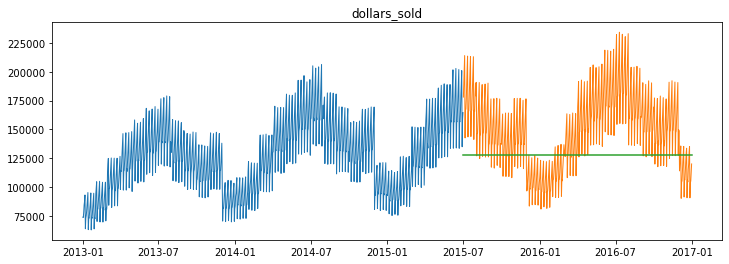

items_sold -- RMSE: 7378


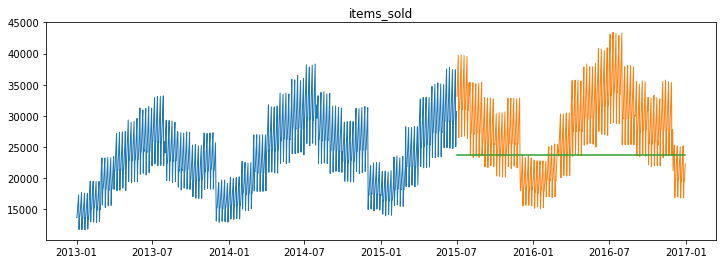

In [79]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [80]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg',
                            target_var = col)
    
eval_df

,model_type,target_var,rmse
0,last_ovserved_value,dollars_sold,35402.0
1,last_ovserved_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d_moving_avg,dollars_sold,39664.0
5,30d_moving_avg,items_sold,7378.0
6,30d_moving_avg,dollars_sold,39664.0
7,30d_moving_avg,items_sold,7378.0


In [87]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    dollars = round(train['dollars_sold'].rolling(1).mean()[-1], 2)
    items = round(train['items_sold'].rolling(1).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
for col in train.columns:
    eval_df = append_eval_df(model_type = model_type,
                        target_var = col)

In [88]:
eval_df

,model_type,target_var,rmse
0,last_ovserved_value,dollars_sold,35402.0
1,last_ovserved_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d_moving_avg,dollars_sold,39664.0
5,30d_moving_avg,items_sold,7378.0
6,30d_moving_avg,dollars_sold,39664.0
7,30d_moving_avg,items_sold,7378.0
8,1d_moving_avg,dollars_sold,35402.0
9,1d_moving_avg,items_sold,6621.0


In [92]:
min_items_rmse = eval_df[eval_df.target_var == 'items_sold']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
1,last_ovserved_value,items_sold,6621.0
9,1d_moving_avg,items_sold,6621.0
11,1d_moving_avg,items_sold,6621.0
13,1d_moving_avg,items_sold,6621.0
15,104d_moving_avg,items_sold,6621.0


In [93]:
from vega_datasets import data
stocks = data.stocks()

In [94]:
stocks.head()

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45


In [96]:
 df = stocks.pivot_table('price', 'date', 'symbol')

In [97]:
df.head()

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2000-01-01,25.94,64.56,NaN,100.52,39.81
2000-02-01,28.66,68.87,NaN,92.11,36.35
2000-03-01,33.95,67.00,NaN,106.11,43.22
2000-04-01,31.01,55.19,NaN,99.95,28.37
2000-05-01,21.00,48.31,NaN,96.31,25.45


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2000-01-01 to 2010-03-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    123 non-null    float64
 1   AMZN    123 non-null    float64
 2   GOOG    68 non-null     float64
 3   IBM     123 non-null    float64
 4   MSFT    123 non-null    float64
dtypes: float64(5)
memory usage: 5.8 KB


In [104]:
df.drop(columns='GOOG', inplace=True)

# Split Data

In [105]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [106]:
train.shape, validate.shape, test.shape

((61, 4), (36, 4), (26, 4))

- Verify splits

In [107]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [108]:
print(df.head(1) == train.head(1))


symbol      AAPL  AMZN   IBM  MSFT
date                              
2000-01-01  True  True  True  True


- Is the last row of train the month before the first row of validate? And the same for validate to test?

In [109]:

pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

symbol,AAPL,AMZN,IBM,MSFT
date,,,,
2008-01-01,135.36,77.70,102.75,31.13
2008-02-01,125.02,64.47,109.64,26.07


- Is the last row of test the same as the last row of our original dataframe?



In [110]:
pd.concat([test.tail(1), df.tail(1)])


symbol,AAPL,AMZN,IBM,MSFT
date,,,,
2010-03-01,223.02,128.82,125.55,28.8
2010-03-01,223.02,128.82,125.55,28.8


Let's plot our data first, viewing where the data is split into train and test.



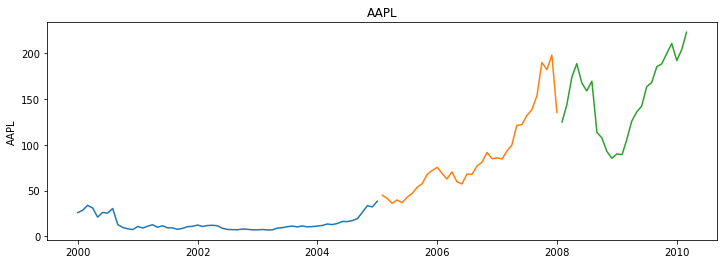

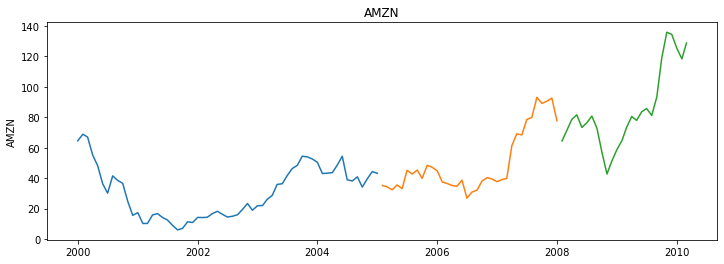

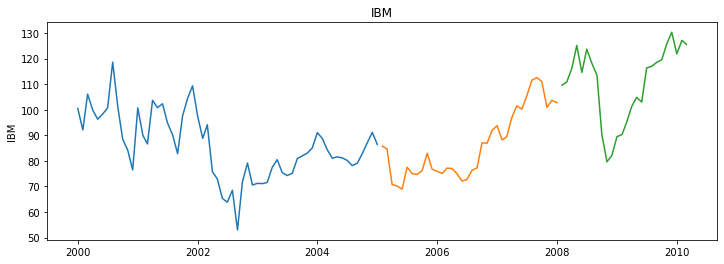

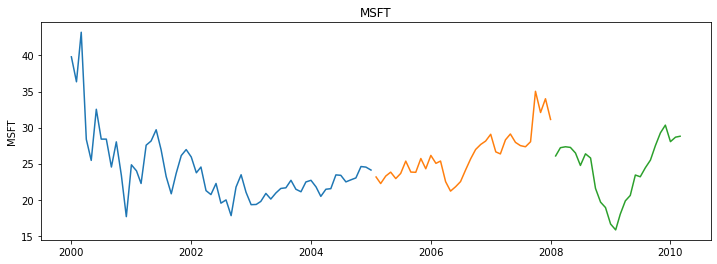

In [111]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

- Before we try out different methods for forecasting stock prices, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.



In [112]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

- plot_and_eval() will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [113]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

- Write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object. Which we will create an empty eval_df dataframe object to start.

In [114]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [115]:
eval_df

,model_type,target_var,rmse


# Forecast

**Last Observed Value**

- Make Predictions

In [122]:
apple = train['AAPL'][-1:][0]
ibm = train['IBM'][-1:][0]
amazon = train['AMZN'][-1:][0]
microsoft = train['MSFT'][-1:][0]

yhat_df = pd.DataFrame({'AAPL': [apple], 'AMZN': [amazon], 'IBM': [ibm], 'AMZN': [amazon], 'MSFT': [microsoft] }, 
                       index = validate.index)

yhat_df.head(2)


,AAPL,AMZN,IBM,MSFT
date,,,,
2005-02-01,38.45,43.22,86.39,24.11
2005-03-01,38.45,43.22,86.39,24.11


- Plot Actual vs. Predicted Values

AAPL -- RMSE: 65


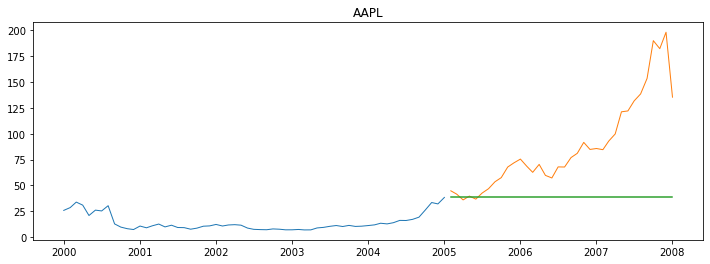

AMZN -- RMSE: 21


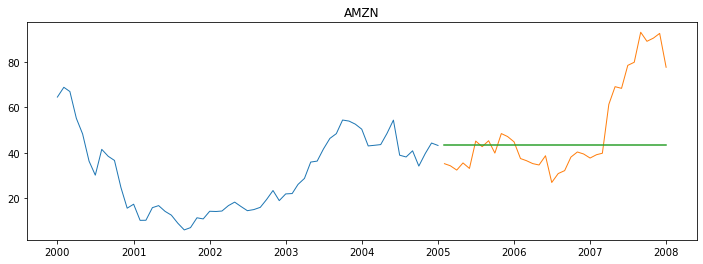

IBM -- RMSE: 13


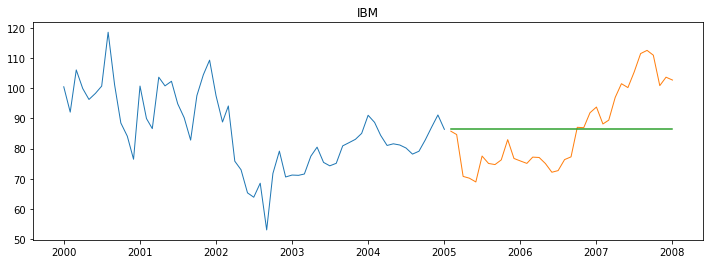

MSFT -- RMSE: 4


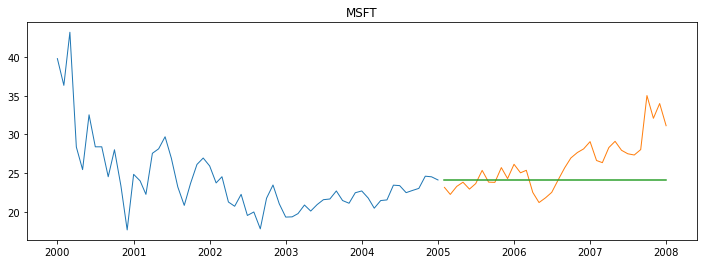

In [123]:
for col in train.columns:
    plot_and_eval(col)

- Evaluate

In [124]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [125]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AAPL,65.0
1,last_observed_value,AMZN,21.0
2,last_observed_value,IBM,13.0
3,last_observed_value,MSFT,4.0


**Simple Average**

- Make Predictions

In [126]:
apple = train['AAPL'].mean()
ibm = train['IBM'].mean()
amazon = train['AMZN'].mean()
microsoft = train['MSFT'].mean()


def make_predictions():
    yhat_df = pd.DataFrame({'AAPL': [apple],
                            'IBM': [ibm],
                            'AMZN': [amazon],
                            'MSFT': [microsoft]
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [127]:
yhat_df.head(2)


,AAPL,IBM,AMZN,MSFT
date,,,,
2005-02-01,14.283443,86.045902,31.136885,24.091475
2005-03-01,14.283443,86.045902,31.136885,24.091475


- Plot Actual vs. Predicted Values



AAPL -- RMSE: 85


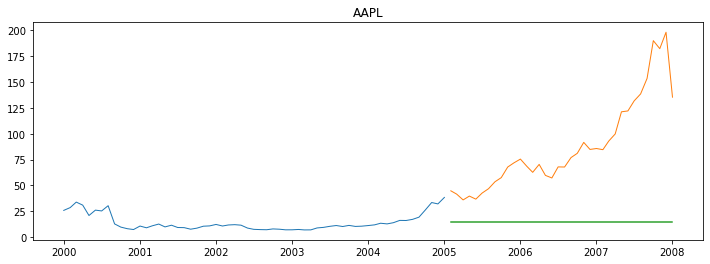

AMZN -- RMSE: 27


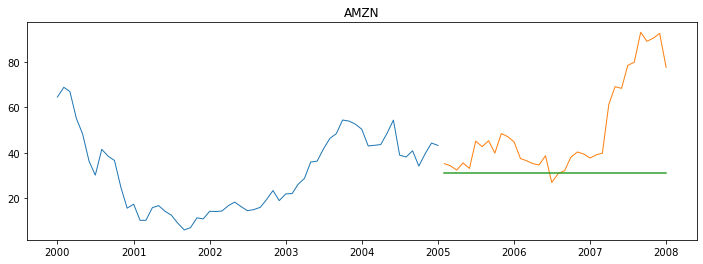

IBM -- RMSE: 13


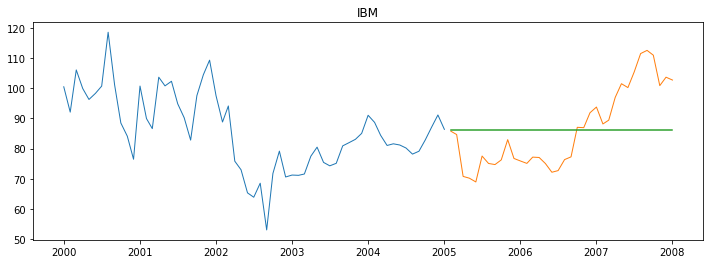

MSFT -- RMSE: 4


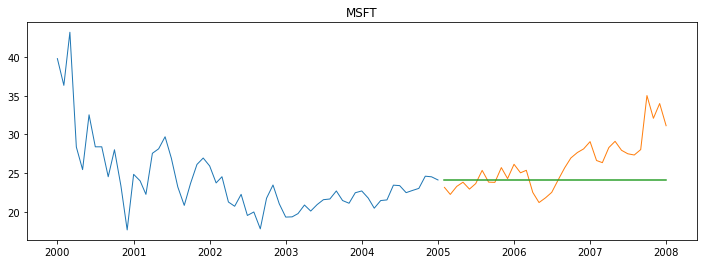

In [128]:
for col in train.columns:
    plot_and_eval(col)